In [ ]:
PROJECT_HOME = "."

# # For Colab

# PROJECT_HOME = "/content/drive/My Drive/Projects/LLM-MCI-detection"

# # Google Drive storage setup
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [ ]:
%%capture
%pip install jieba shap

In [ ]:
import os
import re
import shap
import nltk
import jieba
import scipy
import logging
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score
from matplotlib import pyplot as plt

In [ ]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

re==2.2.1
shap==0.46.0
nltk==3.9.1
jieba==0.42.1
scipy==1.13.0
logging==0.5.1.2
numpy==1.26.4
pandas==2.2.2
xgboost==2.1.3


In [ ]:
random_seed = 42

In [ ]:
N_CV = 5

In [ ]:
figure_folder = os.path.join(PROJECT_HOME, 'figures')
os.makedirs(figure_folder, exist_ok=True)

marker_folder = os.path.join(PROJECT_HOME, 'markers')
os.makedirs(marker_folder, exist_ok=True)

In [ ]:
# tokenizer for Chinese
jieba.setLogLevel(logging.INFO)
# jieba.enable_parallel(4) # parallel processing

In [ ]:
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
english_stopwords = set(stopwords.words('english'))
punctuation_markers = [" ", "'", '"', ".", ",", "。", "，"]
stop_words_list = list(english_stopwords) + punctuation_markers

In [ ]:
text_feature_name = 'text'

In [ ]:
llm_model_names = ["gemma-2-9B", "llama-3.1-8B", "gpt-35-turbo", "gpt-4"]

In [ ]:
def get_text_file_path(name):
    data_dir = os.path.join(PROJECT_HOME, "data")
    return os.path.join(data_dir, "%s.csv" % name)

In [ ]:
label2idx = {
    "NC": "0",
    "MCI": "1"
}

In [ ]:
def text_preprocessing(text):
    text = text.lower()
    # Examiner opening sentence examples
    # Okay, here's the picture.
    # I want you to tell me all of the action that you see, okay?
    # I'm going to show you a picture, and in the picture there's some things going on. What I want you to do is just look at the picture and describe to me any action you see taking place, or anything you see happening.
    # Yeah, tell me the action.
    examiner_words = ["okay", "alright", "tell", "see", "describe", "picture", "action", "happening"]
    for word in examiner_words:
        text = text.replace(word, " ")
    text = text.replace("...", " |pause| ")
    text = text.replace("uh", " |pause| ")
    text = text.replace("um", " |pause| ").replace("umm", " |pause| ").replace("ummm", " |pause| ")
    text = text.replace("hm", " |pause| ").replace("hmm", " |pause| ").replace("hmmm", " |pause| ")
    return text

In [ ]:
df = pd.read_csv(get_text_file_path("original"))
df = df[df['label'].isin(['NC', 'MCI'])].reset_index()
df['text'] = df['text'].apply(text_preprocessing)
print("# of original NC samples: %d" % len(df[df['label']=='NC']))
print("# of original MCI samples: %.d" % len(df[df['label']=='MCI']))
original_NC_MCI_ratio = len(df[df['label']=='NC']) / len(df[df['label']=='MCI'])
df['label'] = df['label'].replace(label2idx)
df['label'] = df['label'].astype(int)

# of original NC samples: 129
# of original MCI samples: 24


In [ ]:
for feature in ['age', 'gender', 'race', 'education', 'MMSE']:
    print("Missing rate (%s): %.1f%%" % (feature, len(df[pd.isnull(df[feature])]) / len(df) * 100))

Missing rate (age): 0.0%
Missing rate (gender): 0.0%
Missing rate (race): 0.0%
Missing rate (education): 0.0%
Missing rate (MMSE): 0.7%


In [ ]:
desc_df = df.copy()
print("All - ")
print("Mean age (std): %.1f (%.1f)" % (desc_df['age'].mean(), desc_df['age'].std()))
print("Percentage of gender=0(female) samples: %.1f%%" % (len(desc_df[desc_df['gender']==0]) / len(desc_df) * 100))
print("Percentage of gender=1(male) samples: %.1f%%" % (len(desc_df[desc_df['gender']==1]) / len(desc_df) * 100))
print("Percentage of race=1 samples: %.1f%%" % (len(desc_df[desc_df['race']==1]) / len(desc_df) * 100))
print("Percentage of race=others samples: %.1f%%" % (len(desc_df[desc_df['race']!=1]) / len(desc_df) * 100))
print("Mean education (std): %.1f (%.1f)" % (desc_df['education'].mean(), desc_df['education'].std()))
print("Mean MMSE (std): %.1f (%.1f)" % (desc_df['MMSE'].mean(), desc_df['MMSE'].std()))

All - 
Mean age (std): 63.6 (8.3)
Percentage of gender=0(female) samples: 57.5%
Percentage of gender=1(male) samples: 42.5%
Percentage of race=1 samples: 99.3%
Percentage of race=others samples: 0.7%
Mean education (std): 14.1 (2.5)
Mean MMSE (std): 28.9 (1.3)


In [ ]:
desc_df = df.copy()
desc_df = desc_df[desc_df['label']==0]
print("NC - ")
print("Mean age (std): %.1f (%.1f)" % (desc_df['age'].mean(), desc_df['age'].std()))
print("Percentage of gender=0(female) samples: %.1f%%" % (len(desc_df[desc_df['gender']==0]) / len(desc_df) * 100))
print("Percentage of gender=1(male) samples: %.1f%%" % (len(desc_df[desc_df['gender']==1]) / len(desc_df) * 100))
print("Percentage of race=1 samples: %.1f%%" % (len(desc_df[desc_df['race']==1]) / len(desc_df) * 100))
print("Percentage of race=others samples: %.1f%%" % (len(desc_df[desc_df['race']!=1]) / len(desc_df) * 100))
print("Mean education (std): %.1f (%.1f)" % (desc_df['education'].mean(), desc_df['education'].std()))
print("Mean MMSE (std): %.1f (%.1f)" % (desc_df['MMSE'].mean(), desc_df['MMSE'].std()))

NC - 
Mean age (std): 63.1 (8.1)
Percentage of gender=0(female) samples: 62.0%
Percentage of gender=1(male) samples: 38.0%
Percentage of race=1 samples: 99.2%
Percentage of race=others samples: 0.8%
Mean education (std): 13.9 (2.4)
Mean MMSE (std): 29.1 (1.2)


In [ ]:
desc_df = df.copy()
desc_df = desc_df[desc_df['label']==1]
print("MCI - ")
print("Mean age (std): %.1f (%.1f)" % (desc_df['age'].mean(), desc_df['age'].std()))
print("Percentage of gender=0(female) samples: %.1f%%" % (len(desc_df[desc_df['gender']==0]) / len(desc_df) * 100))
print("Percentage of gender=1(male) samples: %.1f%%" % (len(desc_df[desc_df['gender']==1]) / len(desc_df) * 100))
print("Percentage of race=1 samples: %.1f%%" % (len(desc_df[desc_df['race']==1]) / len(desc_df) * 100))
print("Percentage of race=others samples: %.1f%%" % (len(desc_df[desc_df['race']!=1]) / len(desc_df) * 100))
print("Mean education (std): %.1f (%.1f)" % (desc_df['education'].mean(), desc_df['education'].std()))
print("Mean MMSE (std): %.1f (%.1f)" % (desc_df['MMSE'].mean(), desc_df['MMSE'].std()))

MCI - 
Mean age (std): 66.8 (9.2)
Percentage of gender=0(female) samples: 33.3%
Percentage of gender=1(male) samples: 66.7%
Percentage of race=1 samples: 100.0%
Percentage of race=others samples: 0.0%
Mean education (std): 15.3 (3.0)
Mean MMSE (std): 27.9 (1.5)


In [ ]:
observational_df_dict = {}
for llm_model_name in llm_model_names:
    observational_df = pd.read_csv(get_text_file_path("observational_generation_%s" % llm_model_name))
    observational_df = observational_df[observational_df['label']=="MCI"]
    observational_df['text'] = observational_df['text'].apply(text_preprocessing)
    vectorizer = TfidfVectorizer()
    outlier_scores = LocalOutlierFactor(n_neighbors=20, contamination=0.1).fit_predict(vectorizer.fit_transform(observational_df[text_feature_name]))
    observational_df = observational_df[outlier_scores==1]
    n_outliers = (outlier_scores!=1).sum()
    print("# of new MCI samples via observational generation (%s): %d (%d outliers removed)" % (llm_model_name, len(observational_df[observational_df['label']=='MCI']), n_outliers))
    observational_df = observational_df.copy()
    observational_df['label'] = observational_df['label'].replace(label2idx)
    observational_df['label'] = observational_df['label'].astype(int)
    observational_df_dict[llm_model_name] = observational_df

# of new MCI samples via observational generation (gemma-2-9B): 110 (10 outliers removed)
# of new MCI samples via observational generation (llama-3.1-8B): 108 (12 outliers removed)
# of new MCI samples via observational generation (gpt-35-turbo): 105 (12 outliers removed)
# of new MCI samples via observational generation (gpt-4): 108 (12 outliers removed)


In [ ]:
cross_lingual_df_dict = {}
for llm_model_name in llm_model_names:
    cross_lingual_df = pd.read_csv(get_text_file_path("cross-lingual_generation_%s" % llm_model_name))
    cross_lingual_df = cross_lingual_df[cross_lingual_df['label']=="MCI"]
    cross_lingual_df['text'] = cross_lingual_df['text'].apply(text_preprocessing)
    vectorizer = TfidfVectorizer()
    outlier_scores = LocalOutlierFactor(n_neighbors=20, contamination=0.1).fit_predict(vectorizer.fit_transform(cross_lingual_df[text_feature_name]))
    cross_lingual_df = cross_lingual_df[outlier_scores==1]
    n_outliers = (outlier_scores!=1).sum()
    print("# of new MCI samples via cross-lingual generation (%s): %d (%d outliers removed)" % (llm_model_name, len(cross_lingual_df[cross_lingual_df['label']=='MCI']), n_outliers))
    cross_lingual_df = cross_lingual_df.copy()
    cross_lingual_df['label'] = cross_lingual_df['label'].replace(label2idx)
    cross_lingual_df['label'] = cross_lingual_df['label'].astype(int)
    cross_lingual_df_dict[llm_model_name] = cross_lingual_df

# of new MCI samples via cross-lingual generation (gemma-2-9B): 110 (10 outliers removed)
# of new MCI samples via cross-lingual generation (llama-3.1-8B): 108 (12 outliers removed)
# of new MCI samples via cross-lingual generation (gpt-35-turbo): 107 (12 outliers removed)
# of new MCI samples via cross-lingual generation (gpt-4): 106 (12 outliers removed)


In [ ]:
counterfactual_df_dict = {}
for llm_model_name in llm_model_names:
    counterfactual_df = pd.read_csv(get_text_file_path("counterfactual_generation_%s" % llm_model_name))
    counterfactual_df = counterfactual_df[counterfactual_df['label']=="MCI"]
    counterfactual_df['text'] = counterfactual_df['text'].apply(text_preprocessing)
    vectorizer = TfidfVectorizer()
    outlier_scores = LocalOutlierFactor(n_neighbors=20, contamination=0.1).fit_predict(vectorizer.fit_transform(counterfactual_df[text_feature_name]))
    counterfactual_df = counterfactual_df[outlier_scores==1]
    n_outliers = (outlier_scores!=1).sum()
    print("# of counterfactual MCI samples via counterfactual generation (%s): %d (%d outliers removed)" % (llm_model_name, len(counterfactual_df[counterfactual_df['label']=='MCI']), n_outliers))
    counterfactual_df = counterfactual_df.copy()
    counterfactual_df['label'] = counterfactual_df['label'].replace(label2idx)
    counterfactual_df['label'] = counterfactual_df['label'].astype(int)
    counterfactual_df_dict[llm_model_name] = counterfactual_df

# of counterfactual MCI samples via counterfactual generation (gemma-2-9B): 116 (13 outliers removed)
# of counterfactual MCI samples via counterfactual generation (llama-3.1-8B): 116 (13 outliers removed)
# of counterfactual MCI samples via counterfactual generation (gpt-35-turbo): 109 (13 outliers removed)
# of counterfactual MCI samples via counterfactual generation (gpt-4): 110 (13 outliers removed)


# Evaluation metrics

In [ ]:
def calculate_one_fold_scores(y_test, y_pred):
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    # In the binary case, we can extract true positives, etc. as follows:
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) # Sensitivity, aka true positive rate = TP / (TP + FN)
    return (sensitivity, f1_score(y_test, y_pred))

def calculate_cv_scores(records):
    score_df = pd.DataFrame(records, columns=['sensitivity', 'f1_score'])
    score_df = score_df.mean(axis=0)
    return score_df

# Original samples

In [ ]:
skf = StratifiedKFold(n_splits=N_CV, shuffle=True, random_state=random_seed)
score_dfs = []
original_df = df.copy()

for i, (train_index, test_index) in enumerate(skf.split(original_df.drop(columns=["label"]), original_df['label'])):

    TfidfVectorizer(tokenizer=jieba.lcut, token_pattern=None, stop_words=stop_words_list)

    X_train_original = original_df.iloc[train_index][text_feature_name]
    y_train_original = original_df.iloc[train_index]['label']
    X_test = original_df.iloc[test_index][text_feature_name]
    y_test = original_df.iloc[test_index]['label']

    X_train_original = vectorizer.fit_transform(X_train_original).toarray()
    X_test = vectorizer.transform(X_test).toarray()

    clf = xgb.XGBClassifier(n_estimators=100, scale_pos_weight=original_NC_MCI_ratio, objective="binary:logistic", random_state=random_seed)
    clf.fit(X_train_original, y_train_original)

    y_pred = clf.predict(X_test)
    score_dfs.append(calculate_one_fold_scores(y_test, y_pred))

cv_score_df = calculate_cv_scores(score_dfs)
print("Baseline (original data) - Sensitivity: %.2f, F1 Score: %.2f" % (cv_score_df['sensitivity'], cv_score_df['f1_score']))

Baseline (original data) - Sensitivity: 0.04, F1 Score: 0.04


# Original samples + new MCI samples via observational generation

In [ ]:
for llm_model_name in llm_model_names:
    skf = StratifiedKFold(n_splits=N_CV, shuffle=True, random_state=random_seed)
    score_dfs = []
    original_df = df.copy()

    for i, (train_index, test_index) in enumerate(skf.split(original_df.drop(columns=["label"]), original_df['label'])):

        vectorizer = TfidfVectorizer(tokenizer=jieba.lcut, token_pattern=None, stop_words=stop_words_list)

        original_train_index = original_df.iloc[train_index]['index']
        X_train_original = original_df.iloc[train_index][text_feature_name]
        y_train_original = original_df.iloc[train_index]['label']
        X_test = original_df.iloc[test_index][text_feature_name]
        y_test = original_df.iloc[test_index]['label']

        observational_df = observational_df_dict[llm_model_name].copy()
        X_train_observational_generation = observational_df[observational_df['index'].isin(original_train_index)].drop(columns=["index"])[text_feature_name]
        y_train_observational_generation= observational_df[observational_df['index'].isin(original_train_index)]['label']

        X_train = pd.concat([X_train_original, X_train_observational_generation], axis=0)
        y_train = pd.concat([y_train_original, y_train_observational_generation], axis=0)

        X_train = vectorizer.fit_transform(X_train).toarray()
        X_test = vectorizer.transform(X_test).toarray()

        clf = xgb.XGBClassifier(n_estimators=100, objective="binary:logistic", random_state=random_seed)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        score_dfs.append(calculate_one_fold_scores(y_test, y_pred))

    cv_score_df = calculate_cv_scores(score_dfs)
    print("%s - Sensitivity: %.2f, F1 Score: %.2f" % ("Observational generation (%s)" % llm_model_name, cv_score_df['sensitivity'], cv_score_df['f1_score']))

Observational generation (gemma-2-9B) - Sensitivity: 0.12, F1 Score: 0.15
Observational generation (llama-3.1-8B) - Sensitivity: 0.20, F1 Score: 0.21
Observational generation (gpt-35-turbo) - Sensitivity: 0.20, F1 Score: 0.21
Observational generation (gpt-4) - Sensitivity: 0.24, F1 Score: 0.24


# Original samples + new MCI samples via cross-lingual generation

In [ ]:
for llm_model_name in llm_model_names:
    skf = StratifiedKFold(n_splits=N_CV, shuffle=True, random_state=random_seed)
    score_dfs = []
    original_df = df.copy()

    for i, (train_index, test_index) in enumerate(skf.split(original_df.drop(columns=["label"]), original_df['label'])):

        vectorizer = TfidfVectorizer(tokenizer=jieba.lcut, token_pattern=None, stop_words=stop_words_list)

        original_train_index = original_df.iloc[train_index]['index']
        X_train_original = original_df.iloc[train_index][text_feature_name]
        y_train_original = original_df.iloc[train_index]['label']
        X_test = original_df.iloc[test_index][text_feature_name]
        y_test = original_df.iloc[test_index]['label']

        cross_lingual_df = cross_lingual_df_dict[llm_model_name].copy()
        X_train_cross_lingual_generation = cross_lingual_df[cross_lingual_df['index'].isin(original_train_index)].drop(columns=["index"])[text_feature_name]
        y_train_cross_lingual_generation= cross_lingual_df[cross_lingual_df['index'].isin(original_train_index)]['label']

        X_train = pd.concat([X_train_original, X_train_cross_lingual_generation], axis=0)
        y_train = pd.concat([y_train_original, y_train_cross_lingual_generation], axis=0)

        X_train = vectorizer.fit_transform(X_train).toarray()
        X_test = vectorizer.transform(X_test).toarray()

        clf = xgb.XGBClassifier(n_estimators=100, objective="binary:logistic", random_state=random_seed)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        score_dfs.append(calculate_one_fold_scores(y_test, y_pred))

    cv_score_df = calculate_cv_scores(score_dfs)
    print("%s - Sensitivity: %.2f, F1 Score: %.2f" % ("Cross-lingual generation (%s)" % llm_model_name, cv_score_df['sensitivity'], cv_score_df['f1_score']))

Cross-lingual generation (gemma-2-9B) - Sensitivity: 0.04, F1 Score: 0.06
Cross-lingual generation (llama-3.1-8B) - Sensitivity: 0.20, F1 Score: 0.26
Cross-lingual generation (gpt-35-turbo) - Sensitivity: 0.08, F1 Score: 0.11
Cross-lingual generation (gpt-4) - Sensitivity: 0.08, F1 Score: 0.11


# Original samples + new MCI samples via counterfactual generation

In [ ]:
for llm_model_name in llm_model_names:
    skf = StratifiedKFold(n_splits=N_CV, shuffle=True, random_state=random_seed)
    score_dfs = []
    original_df = df.copy()

    for i, (train_index, test_index) in enumerate(skf.split(original_df.drop(columns=["label"]), original_df['label'])):

        vectorizer = TfidfVectorizer(tokenizer=jieba.lcut, token_pattern=None, stop_words=stop_words_list)

        original_train_index = original_df.iloc[train_index]['index']
        X_train_original = original_df.iloc[train_index][text_feature_name]
        y_train_original = original_df.iloc[train_index]['label']
        X_test = original_df.iloc[test_index][text_feature_name]
        y_test = original_df.iloc[test_index]['label']

        counterfactual_df = counterfactual_df_dict[llm_model_name].copy()
        X_train_counterfactual_generation = counterfactual_df[counterfactual_df['index'].isin(original_train_index)].drop(columns=["index"])[text_feature_name]
        y_train_counterfactual_generation= counterfactual_df[counterfactual_df['index'].isin(original_train_index)]['label']

        X_train = pd.concat([X_train_original, X_train_counterfactual_generation], axis=0)
        y_train = pd.concat([y_train_original, y_train_counterfactual_generation], axis=0)

        X_train = vectorizer.fit_transform(X_train).toarray()
        X_test = vectorizer.transform(X_test).toarray()

        clf = xgb.XGBClassifier(n_estimators=100, objective="binary:logistic", random_state=random_seed)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        score_dfs.append(calculate_one_fold_scores(y_test, y_pred))

    cv_score_df = calculate_cv_scores(score_dfs)
    print("%s - Sensitivity: %.2f, F1 Score: %.2f" % ("Counterfactual generation (%s)" % llm_model_name, cv_score_df['sensitivity'], cv_score_df['f1_score']))

Counterfactual generation (gemma-2-9B) - Sensitivity: 0.08, F1 Score: 0.11
Counterfactual generation (llama-3.1-8B) - Sensitivity: 0.37, F1 Score: 0.30
Counterfactual generation (gpt-35-turbo) - Sensitivity: 0.21, F1 Score: 0.15
Counterfactual generation (gpt-4) - Sensitivity: 0.30, F1 Score: 0.30


# Original samples + new MCI samples via observational and cross-lingual generation

In [ ]:
for llm_model_name in llm_model_names:
    skf = StratifiedKFold(n_splits=N_CV, shuffle=True, random_state=random_seed)
    score_dfs = []
    original_df = df.copy()

    for i, (train_index, test_index) in enumerate(skf.split(original_df.drop(columns=["label"]), original_df['label'])):

        vectorizer = TfidfVectorizer(tokenizer=jieba.lcut, token_pattern=None, stop_words=stop_words_list)

        original_train_index = original_df.iloc[train_index]['index']
        X_train_original = original_df.iloc[train_index][text_feature_name]
        y_train_original = original_df.iloc[train_index]['label']
        X_test = original_df.iloc[test_index][text_feature_name]
        y_test = original_df.iloc[test_index]['label']

        observational_df = observational_df_dict[llm_model_name].copy()
        X_train_observational_generation = observational_df[observational_df['index'].isin(original_train_index)].drop(columns=["index"])[text_feature_name]
        y_train_observational_generation= observational_df[observational_df['index'].isin(original_train_index)]['label']

        cross_lingual_df = cross_lingual_df_dict[llm_model_name].copy()
        X_train_cross_lingual_generation = cross_lingual_df[cross_lingual_df['index'].isin(original_train_index)].drop(columns=["index"])[text_feature_name]
        y_train_cross_lingual_generation = cross_lingual_df[cross_lingual_df['index'].isin(original_train_index)]['label']

        X_train = pd.concat([X_train_original, X_train_observational_generation, X_train_cross_lingual_generation], axis=0)
        y_train = pd.concat([y_train_original, y_train_observational_generation, y_train_cross_lingual_generation], axis=0)

        X_train = vectorizer.fit_transform(X_train).toarray()
        X_test = vectorizer.transform(X_test).toarray()

        clf = xgb.XGBClassifier(n_estimators=100, objective="binary:logistic", random_state=random_seed)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        score_dfs.append(calculate_one_fold_scores(y_test, y_pred))

    cv_score_df = calculate_cv_scores(score_dfs)
    print("%s - Sensitivity: %.2f, F1 Score: %.2f" % ("Observational + cross-lingual generation (%s)" % llm_model_name, cv_score_df['sensitivity'], cv_score_df['f1_score']))

Observational + cross-lingual generation (gemma-2-9B) - Sensitivity: 0.08, F1 Score: 0.12
Observational + cross-lingual generation (llama-3.1-8B) - Sensitivity: 0.20, F1 Score: 0.17
Observational + cross-lingual generation (gpt-35-turbo) - Sensitivity: 0.24, F1 Score: 0.23
Observational + cross-lingual generation (gpt-4) - Sensitivity: 0.28, F1 Score: 0.27


# Original samples + new MCI samples via observational and counterfactual generation

In [ ]:
for llm_model_name in llm_model_names:
    skf = StratifiedKFold(n_splits=N_CV, shuffle=True, random_state=random_seed)
    score_dfs = []
    original_df = df.copy()

    for i, (train_index, test_index) in enumerate(skf.split(original_df.drop(columns=["label"]), original_df['label'])):

        vectorizer = TfidfVectorizer(tokenizer=jieba.lcut, token_pattern=None, stop_words=stop_words_list)

        original_train_index = original_df.iloc[train_index]['index']
        X_train_original = original_df.iloc[train_index][text_feature_name]
        y_train_original = original_df.iloc[train_index]['label']
        X_test = original_df.iloc[test_index][text_feature_name]
        y_test = original_df.iloc[test_index]['label']

        observational_df = observational_df_dict[llm_model_name].copy()
        X_train_observational_generation = observational_df[observational_df['index'].isin(original_train_index)].drop(columns=["index"])[text_feature_name]
        y_train_observational_generation= observational_df[observational_df['index'].isin(original_train_index)]['label']

        counterfactual_df = counterfactual_df_dict[llm_model_name].copy()
        X_train_counterfactual_generation = counterfactual_df[counterfactual_df['index'].isin(original_train_index)].drop(columns=["index"])[text_feature_name]
        y_train_counterfactual_generation= counterfactual_df[counterfactual_df['index'].isin(original_train_index)]['label']

        X_train = pd.concat([X_train_original, X_train_observational_generation, X_train_counterfactual_generation], axis=0)
        y_train = pd.concat([y_train_original, y_train_observational_generation, y_train_counterfactual_generation], axis=0)

        X_train = vectorizer.fit_transform(X_train).toarray()
        X_test = vectorizer.transform(X_test).toarray()

        clf = xgb.XGBClassifier(n_estimators=100, objective="binary:logistic", random_state=random_seed)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        score_dfs.append(calculate_one_fold_scores(y_test, y_pred))

    cv_score_df = calculate_cv_scores(score_dfs)
    print("%s - Sensitivity: %.2f, F1 Score: %.2f" % ("Observaitonal + counterfactual generation (%s)" % llm_model_name, cv_score_df['sensitivity'], cv_score_df['f1_score']))

Observaitonal + counterfactual generation (gemma-2-9B) - Sensitivity: 0.08, F1 Score: 0.09
Observaitonal + counterfactual generation (llama-3.1-8B) - Sensitivity: 0.20, F1 Score: 0.14
Observaitonal + counterfactual generation (gpt-35-turbo) - Sensitivity: 0.37, F1 Score: 0.26
Observaitonal + counterfactual generation (gpt-4) - Sensitivity: 0.37, F1 Score: 0.31


# Original samples + new MCI samples via cross-lingual and counterfactual generation

In [ ]:
for llm_model_name in llm_model_names:
    skf = StratifiedKFold(n_splits=N_CV, shuffle=True, random_state=random_seed)
    score_dfs = []
    original_df = df.copy()

    for i, (train_index, test_index) in enumerate(skf.split(original_df.drop(columns=["label"]), original_df['label'])):

        vectorizer = TfidfVectorizer(tokenizer=jieba.lcut, token_pattern=None, stop_words=stop_words_list)

        original_train_index = original_df.iloc[train_index]['index']
        X_train_original = original_df.iloc[train_index][text_feature_name]
        y_train_original = original_df.iloc[train_index]['label']
        X_test = original_df.iloc[test_index][text_feature_name]
        y_test = original_df.iloc[test_index]['label']

        cross_lingual_df = cross_lingual_df_dict[llm_model_name].copy()
        X_train_cross_lingual_generation = cross_lingual_df[cross_lingual_df['index'].isin(original_train_index)].drop(columns=["index"])[text_feature_name]
        y_train_cross_lingual_generation = cross_lingual_df[cross_lingual_df['index'].isin(original_train_index)]['label']

        counterfactual_df = counterfactual_df_dict[llm_model_name].copy()
        X_train_counterfactual_generation = counterfactual_df[counterfactual_df['index'].isin(original_train_index)].drop(columns=["index"])[text_feature_name]
        y_train_counterfactual_generation= counterfactual_df[counterfactual_df['index'].isin(original_train_index)]['label']

        X_train = pd.concat([X_train_original, X_train_cross_lingual_generation, X_train_counterfactual_generation], axis=0)
        y_train = pd.concat([y_train_original, y_train_cross_lingual_generation, y_train_counterfactual_generation], axis=0)

        X_train = vectorizer.fit_transform(X_train).toarray()
        X_test = vectorizer.transform(X_test).toarray()

        clf = xgb.XGBClassifier(n_estimators=100, objective="binary:logistic", random_state=random_seed)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        score_dfs.append(calculate_one_fold_scores(y_test, y_pred))

    cv_score_df = calculate_cv_scores(score_dfs)
    print("%s - Sensitivity: %.2f, F1 Score: %.2f" % ("Cross-lingual + counterfactual generation (%s)" % llm_model_name, cv_score_df['sensitivity'], cv_score_df['f1_score']))

Cross-lingual + counterfactual generation (gemma-2-9B) - Sensitivity: 0.16, F1 Score: 0.20
Cross-lingual + counterfactual generation (llama-3.1-8B) - Sensitivity: 0.33, F1 Score: 0.25
Cross-lingual + counterfactual generation (gpt-35-turbo) - Sensitivity: 0.29, F1 Score: 0.23
Cross-lingual + counterfactual generation (gpt-4) - Sensitivity: 0.26, F1 Score: 0.30


# Original samples + all new MCI samples

In [ ]:
for llm_model_name in llm_model_names:
    skf = StratifiedKFold(n_splits=N_CV, shuffle=True, random_state=random_seed)
    score_dfs = []
    original_df = df.copy()

    for i, (train_index, test_index) in enumerate(skf.split(original_df.drop(columns=["label"]), original_df['label'])):

        vectorizer = TfidfVectorizer(tokenizer=jieba.lcut, token_pattern=None, stop_words=stop_words_list)

        original_train_index = original_df.iloc[train_index]['index']
        X_train_original = original_df.iloc[train_index][text_feature_name]
        y_train_original = original_df.iloc[train_index]['label']
        X_test = original_df.iloc[test_index][text_feature_name]
        y_test = original_df.iloc[test_index]['label']

        observational_df = observational_df_dict[llm_model_name].copy()
        X_train_observational_generation = observational_df[observational_df['index'].isin(original_train_index)].drop(columns=["index"])[text_feature_name]
        y_train_observational_generation= observational_df[observational_df['index'].isin(original_train_index)]['label']

        cross_lingual_df = cross_lingual_df_dict[llm_model_name].copy()
        X_train_cross_lingual_generation = cross_lingual_df[cross_lingual_df['index'].isin(original_train_index)].drop(columns=["index"])[text_feature_name]
        y_train_cross_lingual_generation = cross_lingual_df[cross_lingual_df['index'].isin(original_train_index)]['label']

        counterfactual_df = counterfactual_df_dict[llm_model_name].copy()
        X_train_counterfactual_generation = counterfactual_df[counterfactual_df['index'].isin(original_train_index)].drop(columns=["index"])[text_feature_name]
        y_train_counterfactual_generation= counterfactual_df[counterfactual_df['index'].isin(original_train_index)]['label']

        X_train = pd.concat([X_train_original, X_train_observational_generation, X_train_cross_lingual_generation, X_train_counterfactual_generation], axis=0)
        y_train = pd.concat([y_train_original, y_train_observational_generation, y_train_cross_lingual_generation, y_train_counterfactual_generation], axis=0)

        X_train = vectorizer.fit_transform(X_train).toarray()
        X_test = vectorizer.transform(X_test).toarray()

        clf = xgb.XGBClassifier(n_estimators=100, objective="binary:logistic", random_state=random_seed)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        score_dfs.append(calculate_one_fold_scores(y_test, y_pred))

    cv_score_df = calculate_cv_scores(score_dfs)
    print("%s - Sensitivity: %.2f, F1 Score: %.2f" % ("All generation (%s)" % llm_model_name, cv_score_df['sensitivity'], cv_score_df['f1_score']))

All generation (gemma-2-9B) - Sensitivity: 0.12, F1 Score: 0.14
All generation (llama-3.1-8B) - Sensitivity: 0.33, F1 Score: 0.25
All generation (gpt-35-turbo) - Sensitivity: 0.37, F1 Score: 0.27
All generation (gpt-4) - Sensitivity: 0.42, F1 Score: 0.35


# Distance between the original and new samples

In [ ]:
for llm_model_name in llm_model_names:

    original_df = df.copy()
    observational_df = observational_df_dict[llm_model_name].copy()
    cross_lingual_df = cross_lingual_df_dict[llm_model_name].copy()
    counterfactual_df = counterfactual_df_dict[llm_model_name].copy()

    X_NC_original = original_df[original_df['label']==0][text_feature_name]
    X_MCI_original = original_df[original_df['label']==1][text_feature_name]
    X_observational = observational_df[text_feature_name]
    X_cross_lingual = cross_lingual_df[text_feature_name]
    X_counterfactual = counterfactual_df[text_feature_name]

    vectorizer = TfidfVectorizer(tokenizer=jieba.lcut, token_pattern=None, stop_words=stop_words_list)
    vectorizer.fit_transform(pd.concat([X_NC_original, X_MCI_original, X_observational, X_cross_lingual, X_counterfactual])).toarray()

    X_vectors_MCI_original = vectorizer.transform(X_MCI_original).toarray()
    X_vectors_NC_original = vectorizer.transform(X_NC_original).toarray()
    X_vectors_observational = vectorizer.transform(X_observational).toarray()
    X_vectors_cross_lingual = vectorizer.transform(X_cross_lingual).toarray()
    X_vectors_counterfactual = vectorizer.transform(X_counterfactual).toarray()

    dist_observational = scipy.spatial.distance.euclidean(np.mean(X_vectors_MCI_original, axis=0), np.mean(X_vectors_observational, axis=0))
    dist_cross_lingual = scipy.spatial.distance.euclidean(np.mean(X_vectors_MCI_original, axis=0), np.mean(X_vectors_cross_lingual, axis=0))
    dist_counterfactual = scipy.spatial.distance.euclidean(np.mean(X_vectors_NC_original, axis=0), np.mean(X_vectors_counterfactual, axis=0))

    print("Euclidean distance between original and observational (%s): %.2f" % (llm_model_name, dist_observational))
    print("Euclidean distance between original and cross-lingual (%s): %.2f" % (llm_model_name, dist_cross_lingual))
    print("Euclidean distance between original and counterfactual (%s): %.2f" % (llm_model_name, dist_counterfactual))

Euclidean distance between original and observational (gemma-2-9B): 0.54
Euclidean distance between original and cross-lingual (gemma-2-9B): 0.67
Euclidean distance between original and counterfactual (gemma-2-9B): 0.45
Euclidean distance between original and observational (llama-3.1-8B): 0.30
Euclidean distance between original and cross-lingual (llama-3.1-8B): 0.55
Euclidean distance between original and counterfactual (llama-3.1-8B): 0.38
Euclidean distance between original and observational (gpt-35-turbo): 0.35
Euclidean distance between original and cross-lingual (gpt-35-turbo): 0.64
Euclidean distance between original and counterfactual (gpt-35-turbo): 0.30
Euclidean distance between original and observational (gpt-4): 0.28
Euclidean distance between original and cross-lingual (gpt-4): 0.67
Euclidean distance between original and counterfactual (gpt-4): 0.60


# SHAP analysis - original baseline

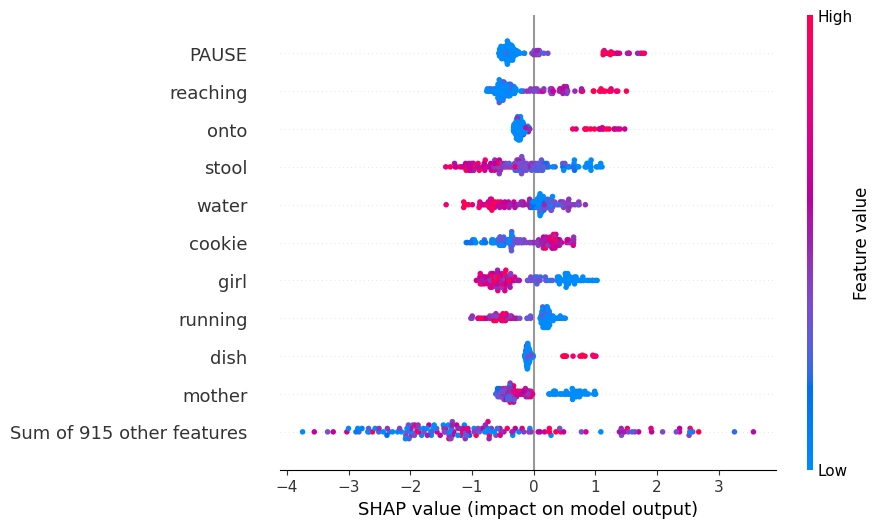

In [ ]:
original_df = df.copy()
original_index = original_df['index']

X_train = original_df[text_feature_name]
y_train = original_df['label']

vectorizer = TfidfVectorizer(tokenizer=jieba.lcut, token_pattern=None, stop_words=stop_words_list)
X_train = vectorizer.fit_transform(X_train).toarray()
X_train = pd.DataFrame(X_train, columns=vectorizer.get_feature_names_out().tolist())
X_train = X_train.rename(columns={"pause": "PAUSE"})

clf = xgb.XGBClassifier(n_estimators=100, objective="binary:logistic", random_state=random_seed)
clf.fit(X_train, y_train)
pred = clf.predict(X_train, output_margin=True)

explainer = shap.TreeExplainer(clf)
explanation = explainer(X_train)
shap.plots.beeswarm(explanation, max_display=11, order=explanation.abs.max(0), show=False)
plt.savefig(os.path.join(figure_folder, "original_baseline.png"), dpi=300, bbox_inches='tight')

with open(os.path.join(marker_folder, "original_baseline.csv"), "w") as output_f:
    output_f.write("feature,score\n")
    feature_scores = np.max(np.abs(explanation.values), axis=0)
    feature_names = vectorizer.get_feature_names_out()
    top_feature_index = feature_scores.argsort()[::-1]
    top_feature_score = feature_scores[top_feature_index]
    feature_count = 0
    for idx, score in zip(top_feature_index, top_feature_score):
        feature_name = feature_names[idx]
        if feature_name == "pause":
            feature_name = "PAUSE" # special keyword for pause terms
        if feature_name == 'ms':
            feature_name = 'seems' # ad-hoc: as 'see' was filtered out previously to remove examiner's words
        feature_name = re.sub("[^A-Za-z]", "", feature_name)
        if feature_name != "":
            output_f.write("%s,%.2f\n" % (feature_name, score))
            feature_count += 1
        if feature_count == 50:
            break

# SHAP analysis - counterfactual generation

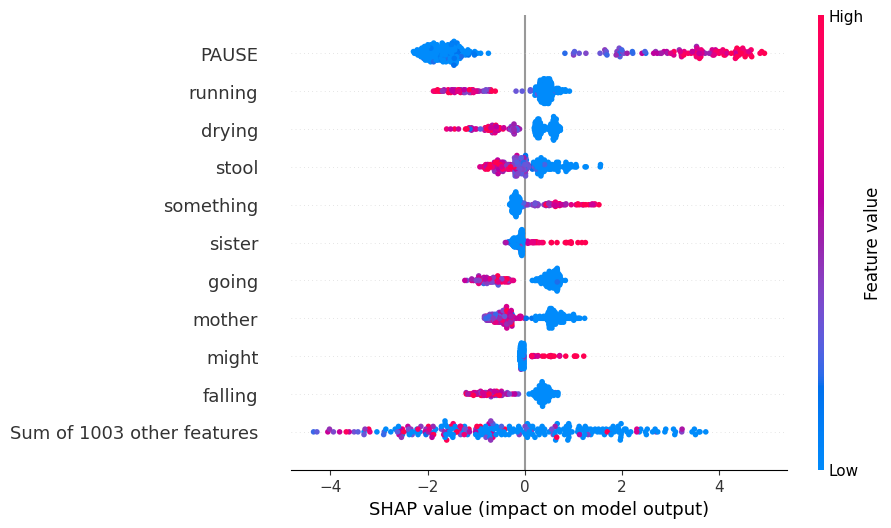

In [ ]:
gpt_model_name = "gpt-4"

original_df = df.copy()
original_index = original_df['index']

X_train_original = original_df[text_feature_name]
y_train_original = original_df['label']

counterfactual_df = counterfactual_df_dict[gpt_model_name].copy()
X_train_counterfactual_generation = counterfactual_df[counterfactual_df['index'].isin(original_index)].drop(columns=["index"])[text_feature_name]
y_train_counterfactual_generation= counterfactual_df[counterfactual_df['index'].isin(original_index)]['label']

X_train = pd.concat([X_train_original, X_train_counterfactual_generation], axis=0)
y_train = pd.concat([y_train_original, y_train_counterfactual_generation], axis=0)

vectorizer = TfidfVectorizer(tokenizer=jieba.lcut, token_pattern=None, stop_words=stop_words_list)
X_train = vectorizer.fit_transform(X_train).toarray()
X_train = pd.DataFrame(X_train, columns=vectorizer.get_feature_names_out().tolist())
X_train = X_train.rename(columns={"pause": "PAUSE"})

clf = xgb.XGBClassifier(n_estimators=100, objective="binary:logistic", random_state=random_seed)
clf.fit(X_train, y_train)
pred = clf.predict(X_train, output_margin=True)

explainer = shap.TreeExplainer(clf)
explanation = explainer(X_train)
shap.plots.beeswarm(explanation, max_display=11, order=explanation.abs.max(0), show=False)
plt.savefig(os.path.join(figure_folder, "counterfactual_generation.png"), dpi=300, bbox_inches='tight')

with open(os.path.join(marker_folder, "couterfactual_generation.csv"), "w") as output_f:
    output_f.write("feature,score\n")
    feature_scores = np.max(np.abs(explanation.values), axis=0)
    feature_names = vectorizer.get_feature_names_out()
    top_feature_index = feature_scores.argsort()[::-1]
    top_feature_score = feature_scores[top_feature_index]
    feature_count = 0
    for idx, score in zip(top_feature_index, top_feature_score):
        feature_name = feature_names[idx]
        if feature_name == "pause":
            feature_name = "PAUSE" # special keyword for pause terms
        if feature_name == 'ms':
            feature_name = 'seems' # ad-hoc: as 'see' was filtered out previously to remove examiner's words
        feature_name = re.sub("[^A-Za-z]", "", feature_name)
        if feature_name != "":
            output_f.write("%s,%.2f\n" % (feature_name, score))
            feature_count += 1
        if feature_count == 50:
            break

# SHAP analysis - all generation

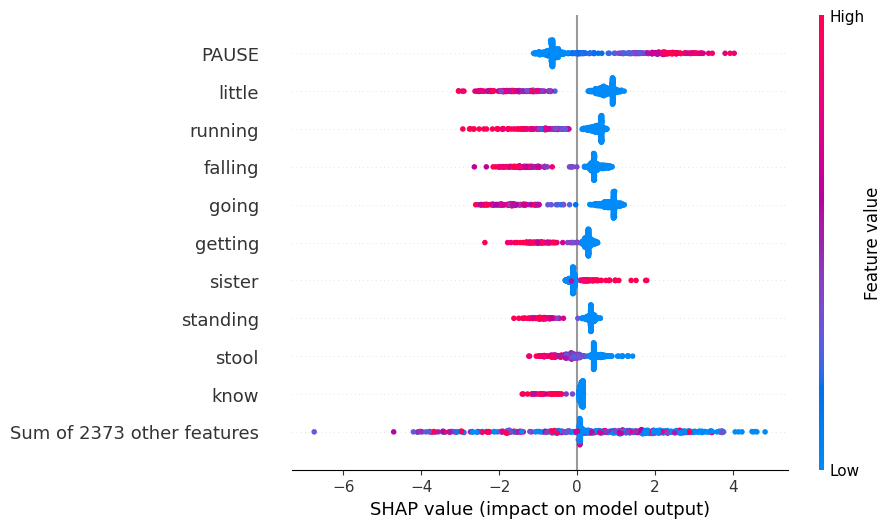

In [ ]:
gpt_model_name = "gpt-4"

original_df = df.copy()
original_index = original_df['index']

X_train_original = original_df[text_feature_name]
y_train_original = original_df['label']

observational_df = observational_df_dict[gpt_model_name].copy()
X_train_observational_generation = observational_df[observational_df['index'].isin(original_index)].drop(columns=["index"])[text_feature_name]
y_train_observational_generation= observational_df[observational_df['index'].isin(original_index)]['label']

cross_lingual_df = cross_lingual_df_dict[gpt_model_name].copy()
X_train_cross_lingual_generation = cross_lingual_df[cross_lingual_df['index'].isin(original_train_index)].drop(columns=["index"])[text_feature_name]
y_train_cross_lingual_generation = cross_lingual_df[cross_lingual_df['index'].isin(original_train_index)]['label']

counterfactual_df = counterfactual_df_dict[gpt_model_name].copy()
X_train_counterfactual_generation = counterfactual_df[counterfactual_df['index'].isin(original_index)].drop(columns=["index"])[text_feature_name]
y_train_counterfactual_generation= counterfactual_df[counterfactual_df['index'].isin(original_index)]['label']

X_train = pd.concat([X_train_original, X_train_observational_generation, X_train_cross_lingual_generation, X_train_counterfactual_generation], axis=0)
y_train = pd.concat([y_train_original, y_train_observational_generation, y_train_cross_lingual_generation, y_train_counterfactual_generation], axis=0)

vectorizer = TfidfVectorizer(tokenizer=jieba.lcut, token_pattern=None, stop_words=stop_words_list)
X_train = vectorizer.fit_transform(X_train).toarray()
X_train = pd.DataFrame(X_train, columns=vectorizer.get_feature_names_out().tolist())
X_train = X_train.rename(columns={"pause": "PAUSE"})

clf = xgb.XGBClassifier(n_estimators=100, objective="binary:logistic", random_state=random_seed)
clf.fit(X_train, y_train)
pred = clf.predict(X_train, output_margin=True)

explainer = shap.TreeExplainer(clf)
explanation = explainer(X_train)
shap.plots.beeswarm(explanation, max_display=11, order=explanation.abs.max(0), show=False)
plt.savefig(os.path.join(figure_folder, "all_generation.png"), dpi=300, bbox_inches='tight')

with open(os.path.join(marker_folder, "all_generation.csv"), "w") as output_f:
    output_f.write("feature,score\n")
    feature_scores = np.max(np.abs(explanation.values), axis=0)
    feature_names = vectorizer.get_feature_names_out()
    top_feature_index = feature_scores.argsort()[::-1]
    top_feature_score = feature_scores[top_feature_index]
    feature_count = 0
    for idx, score in zip(top_feature_index, top_feature_score):
        feature_name = feature_names[idx]
        if feature_name == "pause":
            feature_name = "PAUSE" # special keyword for pause terms
        if feature_name == 'ms':
            feature_name = 'seems' # ad-hoc: as 'see' was filtered out previously to remove examiner's words
        feature_name = re.sub("[^A-Za-z]", "", feature_name)
        if feature_name != "":
            output_f.write("%s,%.2f\n" % (feature_name, score))
            feature_count += 1
        if feature_count == 50:
            break